In [1]:
import pandas as pd
import geopandas as gpd
import pickle
from shapely.geometry import Polygon, MultiPolygon
import numpy as np
import seaborn as sns; sns.set(); sns.set_style("white")
from sklearn.neighbors import BallTree
import folium
import os
import sys

parentdir = os.path.dirname(os.getcwd())
sys.path.insert(0, parentdir)
import KeyFunctions as kf

%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

In [2]:
gdf = kf.load_obj(root_path,"raw_gdf")

In [3]:
sm_gdf = kf.load_obj(root_path,"raw_gdf_Windermere")

In [4]:
gdf["Type"].unique().tolist()

['RailwayStations',
 'FerryTerminals',
 'BusStops',
 'RoadAccidents',
 'Postcodes',
 'UDPRNs',
 'LReg',
 'FireStations',
 'Schools',
 'Crimes',
 'StopAndSearch',
 'Clinic',
 'Dentists',
 'GP',
 'Hospital',
 'Opticians',
 'Pharmacy',
 'Care homes and care at home',
 'All_GB',
 'National_Parks',
 'LocalAuthorities',
 'LSOA',
 'GreenSpace',
 'Rivers',
 'Railway_Lines',
 'Woodland_Region',
 'Urban_Region',
 'Foreshor_Region',
 'Ferry_Line',
 'Coastline',
 'Lakes',
 'Road',
 'MotorwayJunction',
 'Peat',
 'SiteOfScientificInterest',
 'LocalNatureReserve',
 'NationalNatureReserve',
 'SpecialAreaOfConservation',
 'AncientWoodland',
 'ConservationArea',
 'Listed Buildings',
 'MetOffice']

C:\Users\richa\AppData\Local\Temp\ipykernel_19540\340306848.py:5: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sm_gdf.loc[(sm_gdf["Type"]=="Road") & (sm_gdf["Name"]=="Motorway"),:].plot(ax=ax, color='black', linewidth=3, zorder=3)


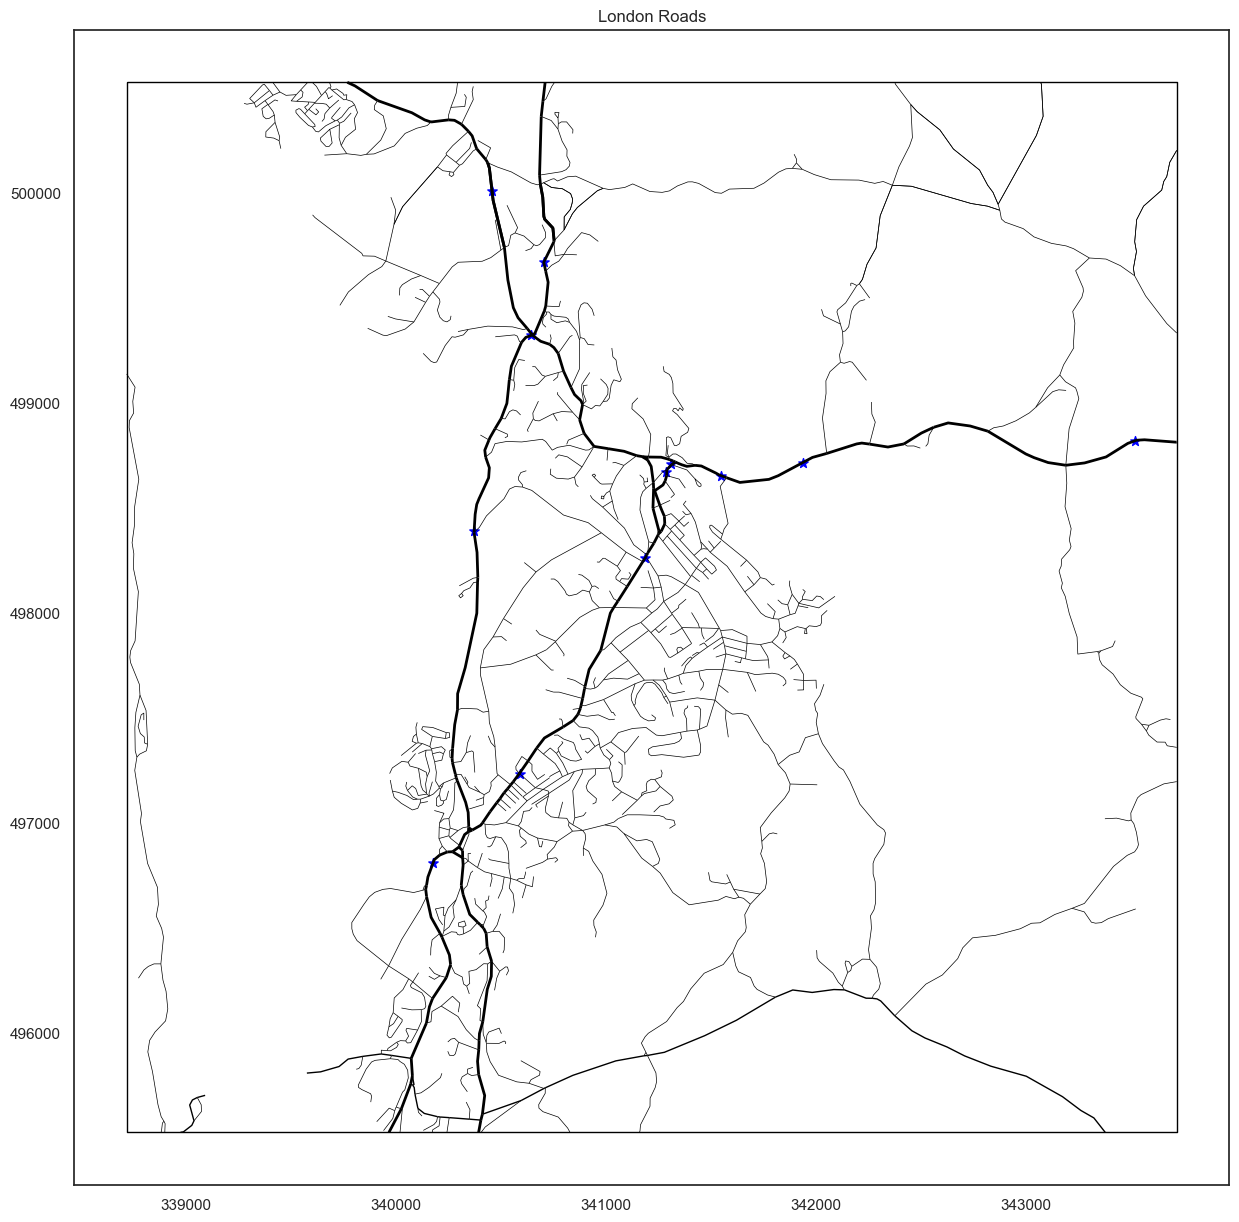

In [5]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.title("London Roads")
sm_gdf.loc[sm_gdf["Type"]=="All_GB",:].plot(ax=ax, color='none', edgecolor='black', zorder=1)
sm_gdf.loc[sm_gdf["Type"]=="RoadAccidents",:].plot(ax=ax, color='blue', marker='*',markersize=50, zorder=2)
sm_gdf.loc[(sm_gdf["Type"]=="Road") & (sm_gdf["Name"]=="Motorway"),:].plot(ax=ax, color='black', linewidth=3, zorder=3)
sm_gdf.loc[(sm_gdf["Type"]=="Road") & (sm_gdf["Name"]=="A Road"),:].plot(ax=ax, color='black', linewidth=2, zorder=4)
sm_gdf.loc[(sm_gdf["Type"]=="Road") & (sm_gdf["Name"]=="B Road"),:].plot(ax=ax, color='black', linewidth=1, zorder=5)
sm_gdf.loc[(sm_gdf["Type"]=="Road") & (~sm_gdf["Name"].isin(["Motorway", "A Road", "B Road"])),:].plot(ax=ax, color='black', linewidth=0.5, zorder=6)
plt.savefig("D:/GeoData/WorkingData/Images/Road_Test.png",dpi=300)
#plt.close(fig)
plt.show()


In [6]:
for i in ['TotalRainfall_mm_2020', 'Sunlight_h_2020', 'AverageTemperature_C_2020', 'GroundFrost_Days_2020', 'Snow_Days_2020']:
    fig, ax = plt.subplots(1, figsize=(30,60))
    plt.title(str(i) + "Across the UK", fontsize='xx-large')
    gdf.loc[gdf["Type"]=="All_GB",:].plot(ax=ax, color='none', edgecolor='black', zorder=1)

    points = gdf.loc[(gdf["Type"]=="MetOffice") & (gdf["Name"]==i) & (gdf["Details_Float"].notna()),:].copy()

    cap = points["Details_Float"].quantile(0.99)
    points["Normalised"] = points["Details_Float"] / cap
    points["Normalised"] = points['Normalised'].where(points['Normalised'] <= 1, 1)  

    points.plot(ax=ax, c="blue", markersize=1, alpha=points["Normalised"])

    legend_points = [round(points["Details_Float"].quantile(0.10),0), round(points["Details_Float"].quantile(0.30),0), round(points["Details_Float"].quantile(0.50),0), round(points["Details_Float"].quantile(0.70),0), round(points["Details_Float"].quantile(0.90),0)]

    for val in legend_points:
        plt.scatter([], [], c="blue", alpha=val/cap, label=str(val))
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title=i, loc='center right', fontsize='large' )

    plt.savefig("D:/GeoData/WorkingData/Images/" + i +'.png',dpi=300)
    plt.close(fig)

In [7]:
#https://towardsdatascience.com/from-kernel-density-estimation-to-spatial-analysis-in-python-64ddcdb6bc9b

def plot_crime_density(name):
    gdf = kf.load_obj(root_path,"raw_gdf_" + name)

    points = gdf.loc[(gdf["Type"]=="Crimes"),:].copy()

    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.title(name + " Crimes")
    gdf.loc[gdf["Type"]=="All_GB",:].plot(ax=ax, color='none', edgecolor='black', zorder=1)
    points.plot(ax=ax)

    gdf.loc[(gdf["Type"]=="Road"),:].plot(ax=ax, color='black', linewidth=0.5, zorder=2)

    # Create thresholds
    levels = [0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]

    kde = sns.kdeplot(
        ax=ax,
        x=points['geometry'].x,
        y= points['geometry'].y,
        levels = levels,
        shade=True,
        cmap='Blues',
        alpha=0.5,
        
    )
    plt.savefig("D:/GeoData/WorkingData/Images/CrimeDensity_" + name +'.png',dpi=300)
    plt.show()

def plot_crime_types(name):
    gdf = kf.load_obj(root_path,"raw_gdf_" + name)
    points = gdf.loc[gdf["Type"]=="Crimes",:]

    # Get Unique crimes
    colour_labels = points.loc[:,"Name"].unique()
    crime_count = len(colour_labels)

    # List of colors in the color palettes
    rgb_values = sns.color_palette("colorblind", crime_count)

    # Map crimes to the colors
    color_map = dict(zip(colour_labels, rgb_values))

    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.title(name +" Crimes by Type")

    gdf.loc[(gdf["Type"]=="Road"),:].plot(ax=ax, color='black', linewidth=0.5, zorder=1)
    for crime in color_map:
        pts=points.loc[points["Name"]==crime,:]
        pts.plot(ax = ax, c=pts['Name'].map(color_map), label=crime)
    ax.legend()

    plt.savefig("D:/GeoData/WorkingData/Images/Crimes By Type " + name +".png",dpi=300)
    plt.show()

def plot_postcodes(name):
    gdf = kf.load_obj(root_path,"raw_gdf_" + name)
    points = gdf.loc[gdf["Type"]=="Postcodes",:]

    fig, ax = plt.subplots(1, figsize=(15,15))
    plt.title(name + " Postcodes")

    gdf.loc[(gdf["Type"]=="Road"),:].plot(ax=ax, color='black', linewidth=0.5, zorder=1)
    points.plot(ax=ax, c="blue", alpha=0.4, markersize=4)

    plt.savefig("D:/GeoData/WorkingData/Images/Postcodes " + name +".png",dpi=300)
    plt.show()


C:\Users\richa\AppData\Local\Temp\ipykernel_19540\769673134.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(
c:\Users\richa\.conda\envs\GeoData\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\richa\.conda\envs\GeoData\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\richa\.conda\envs\GeoData\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

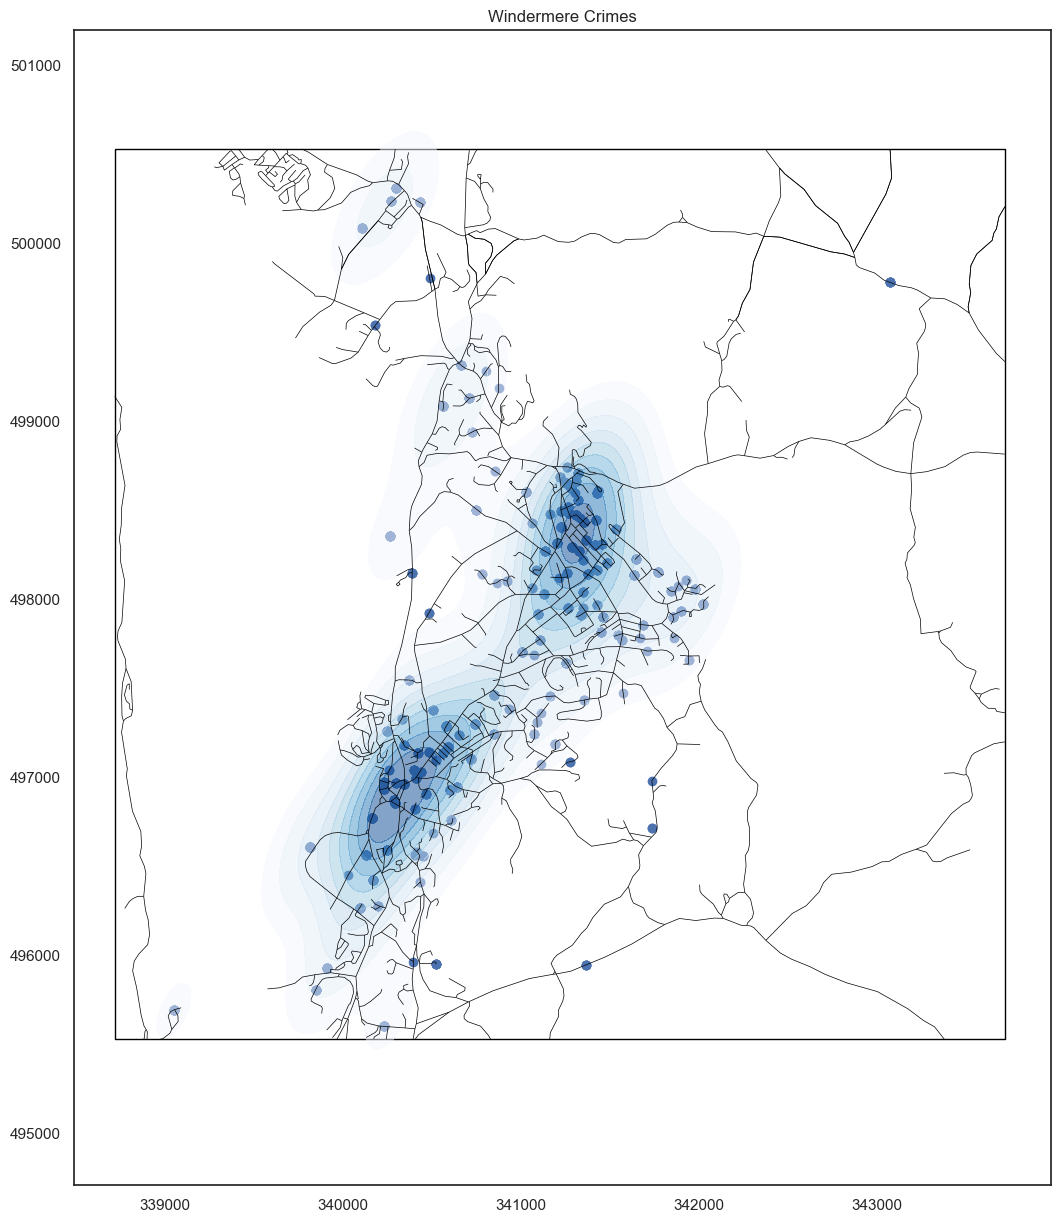

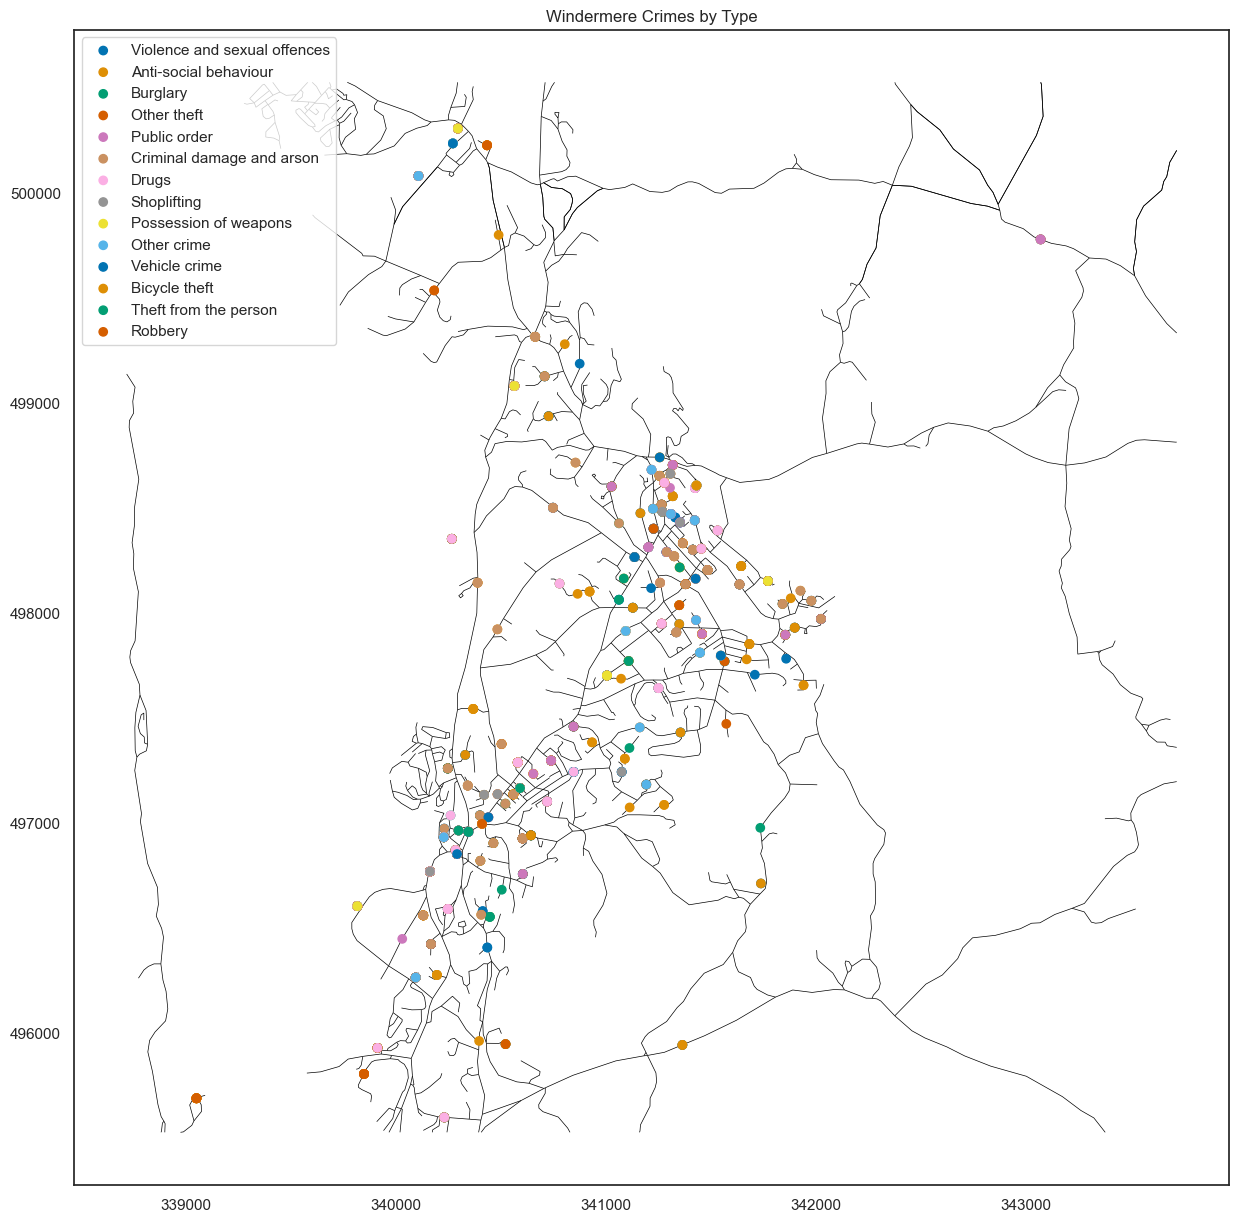

In [8]:
plot_crime_density("Windermere")
plot_crime_types("Windermere")

C:\Users\richa\AppData\Local\Temp\ipykernel_19540\769673134.py:18: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  kde = sns.kdeplot(
c:\Users\richa\.conda\envs\GeoData\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\richa\.conda\envs\GeoData\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\richa\.conda\envs\GeoData\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

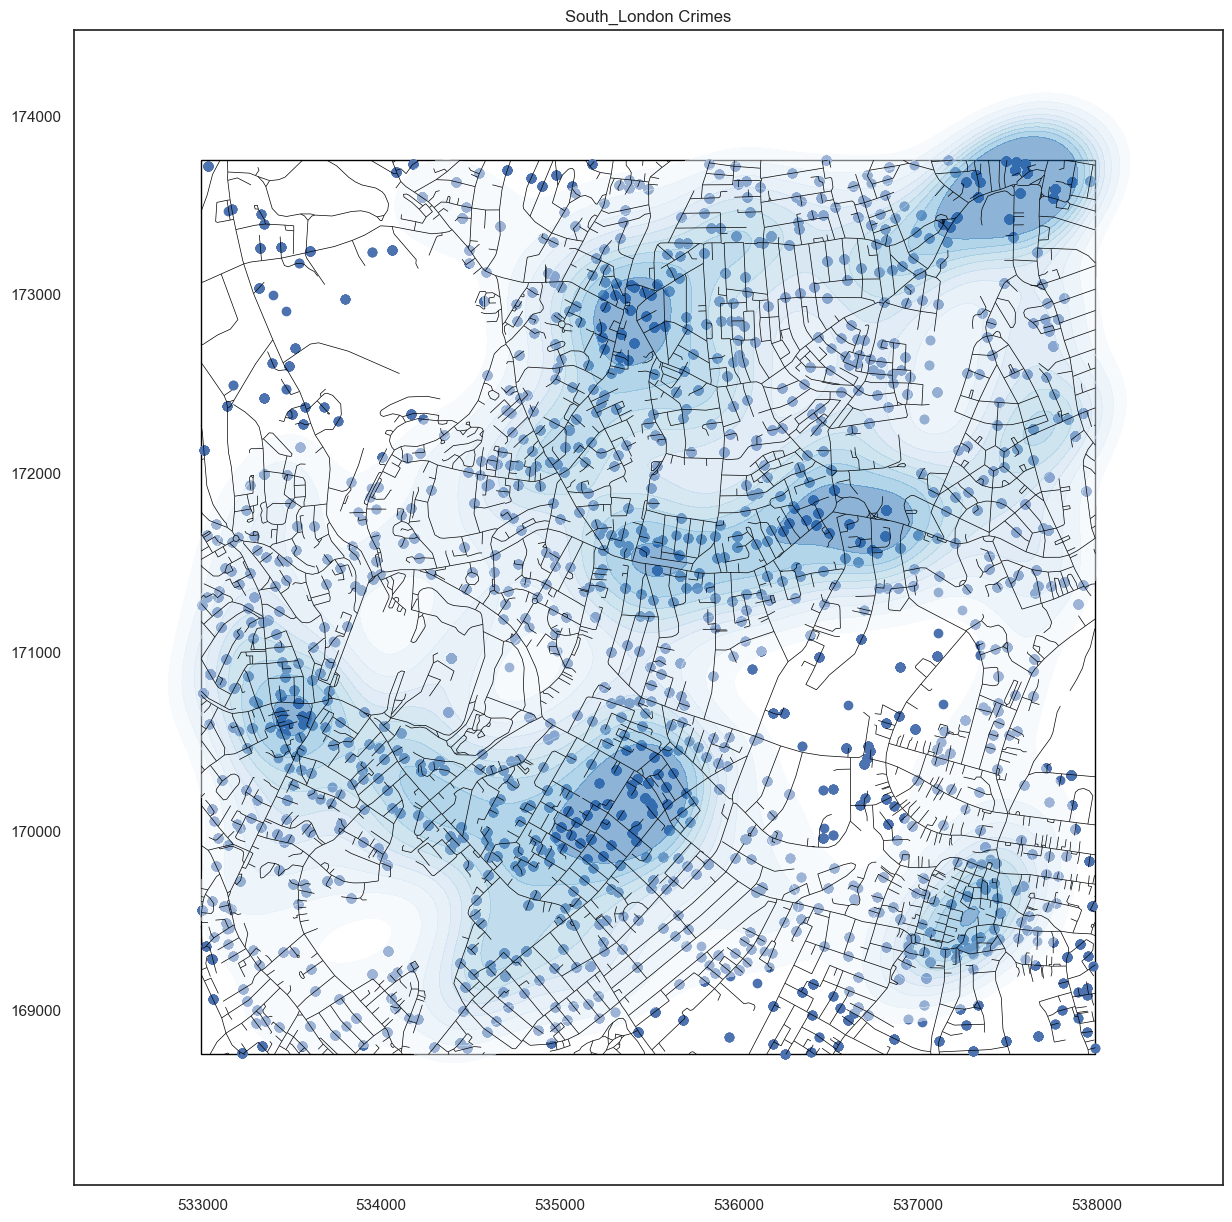

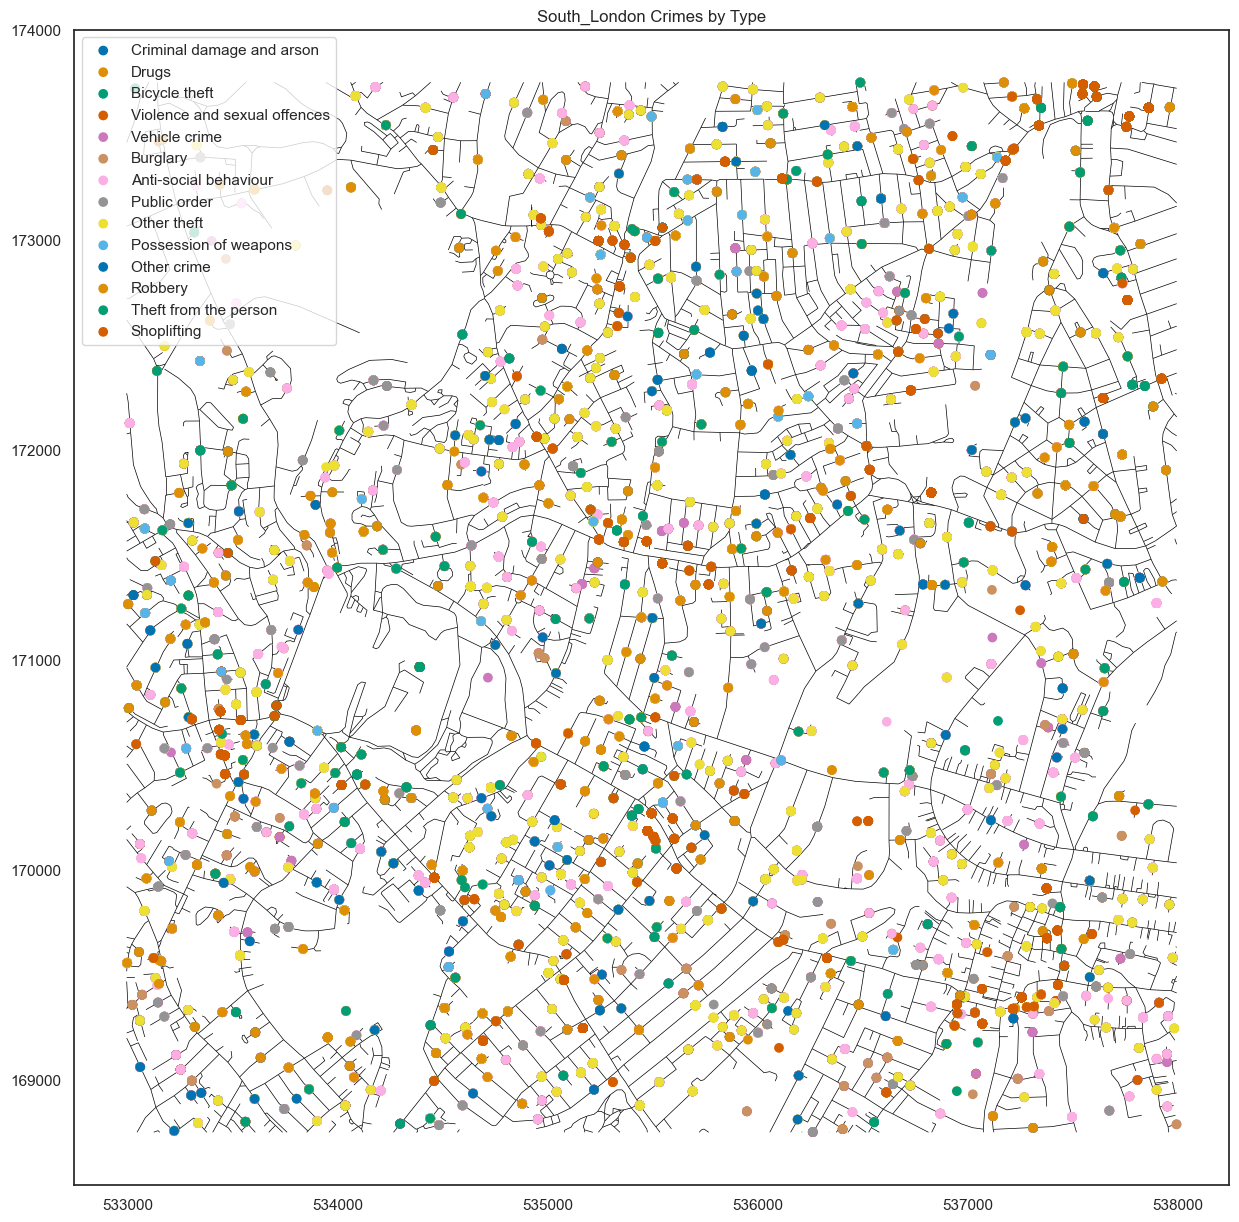

In [9]:
plot_crime_density("South_London")
plot_crime_types("South_London")

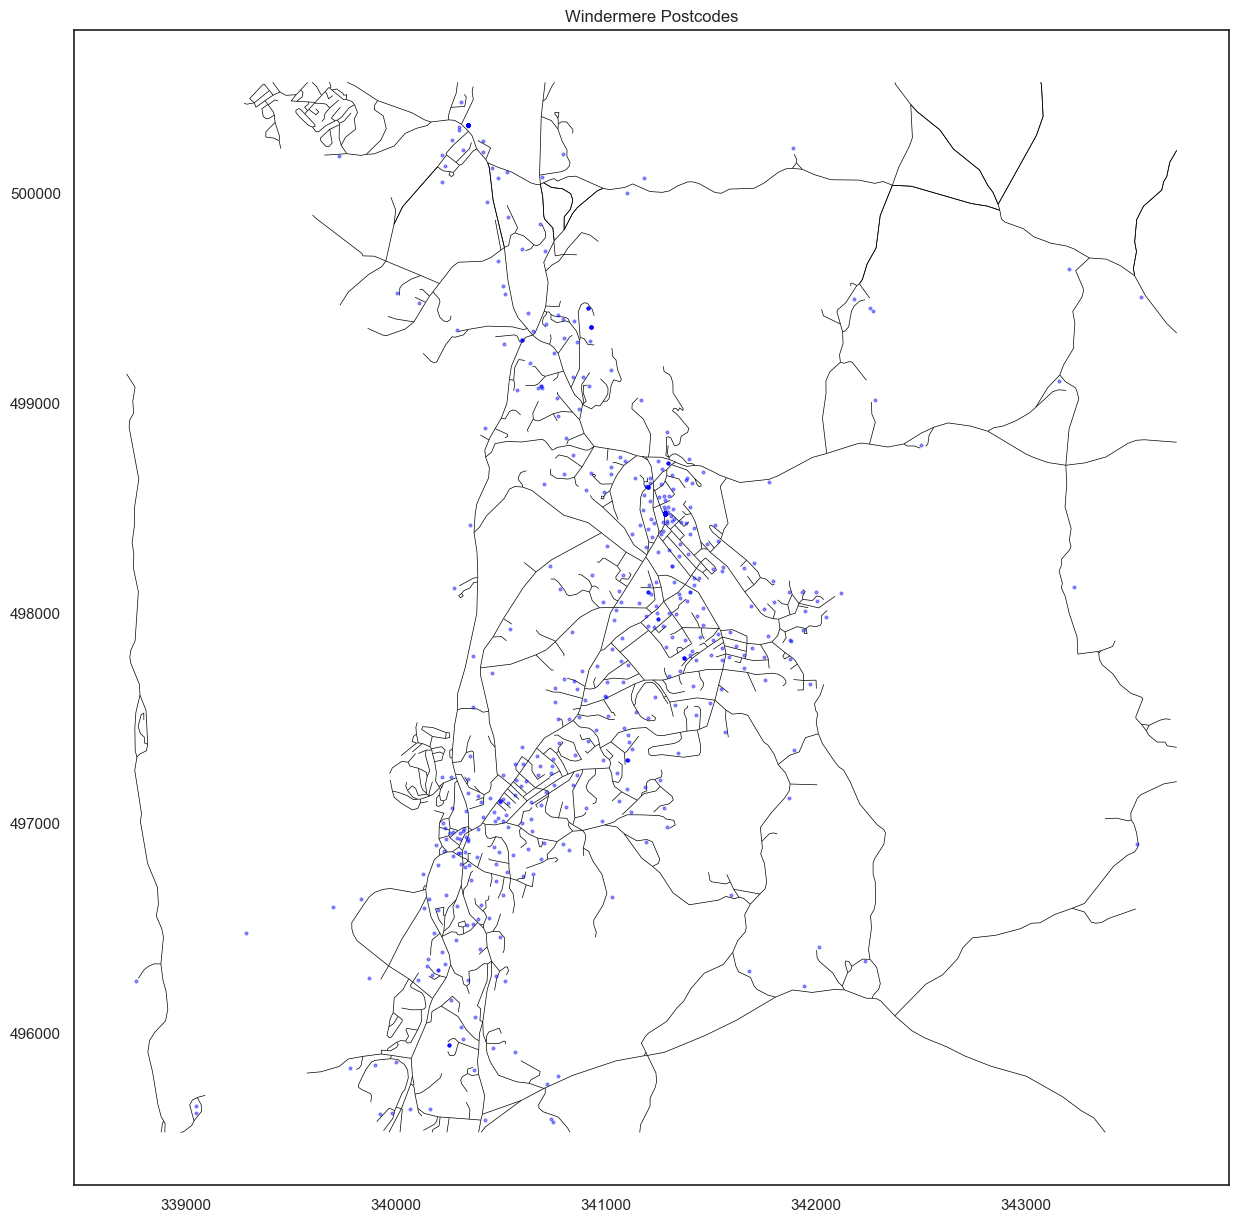

In [10]:
plot_postcodes("Windermere")

Find the number of points within a given radius

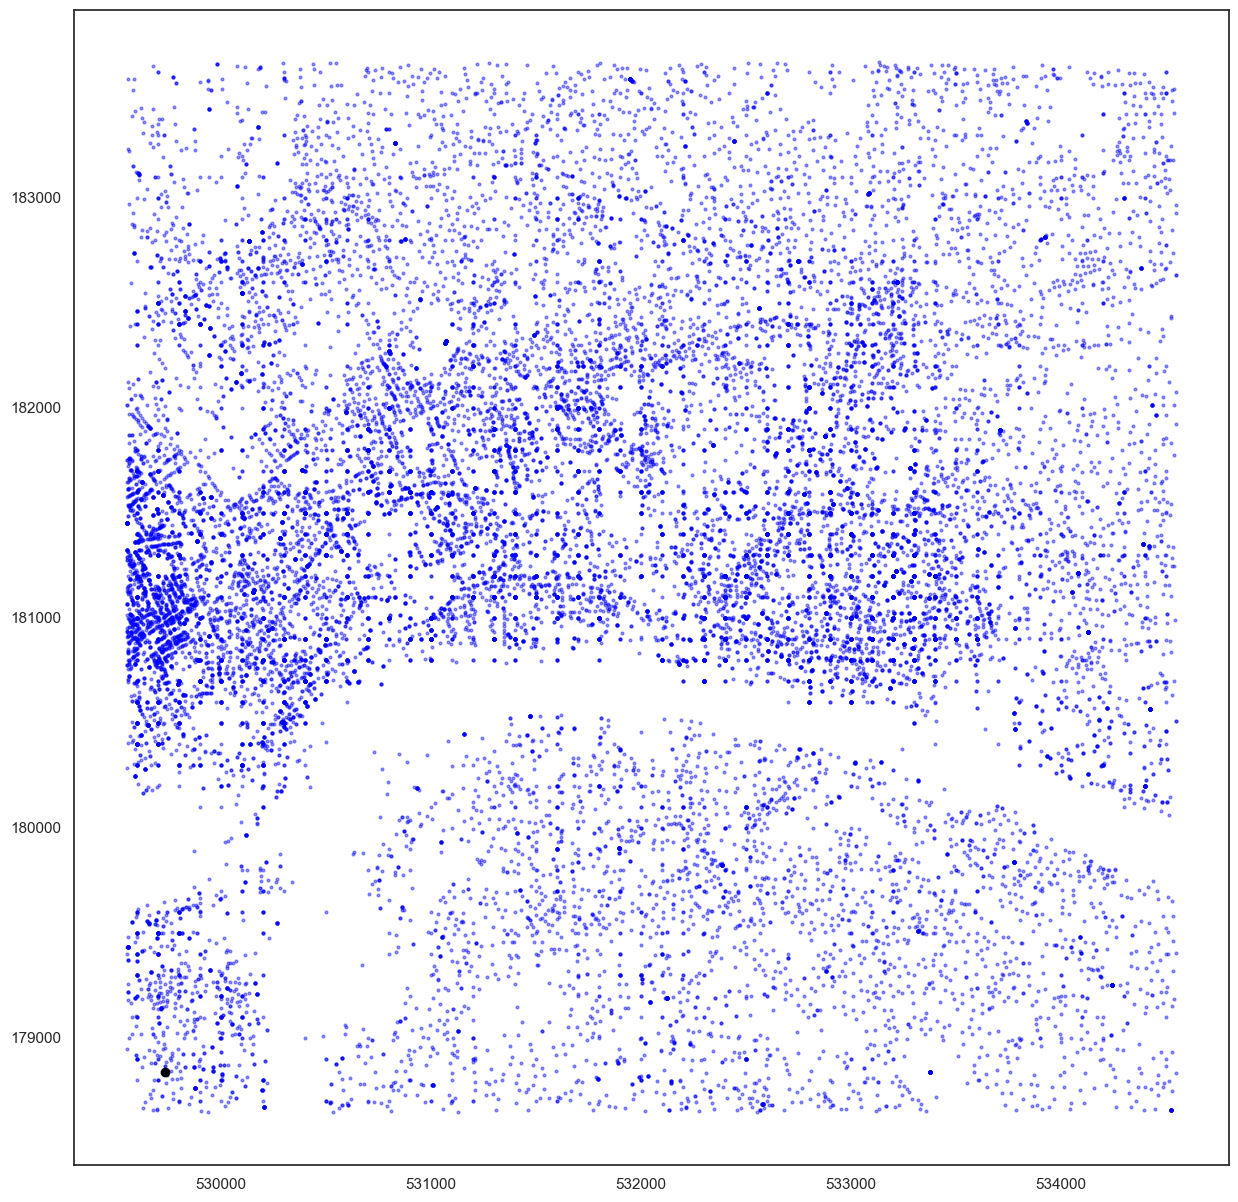

In [12]:
#Find a point
name = "StPauls" 
gdf = kf.load_obj(root_path,"raw_gdf_" + name)
points = gdf.loc[gdf["Type"]=="Postcodes",:]
point = points.iloc[0,:]

fig, ax = plt.subplots(1, figsize=(15,15))
points.plot(ax=ax, c="blue", alpha=0.4, markersize=4)
plt.scatter(point.geometry.x,point.geometry.y,c="black")
plt.show()

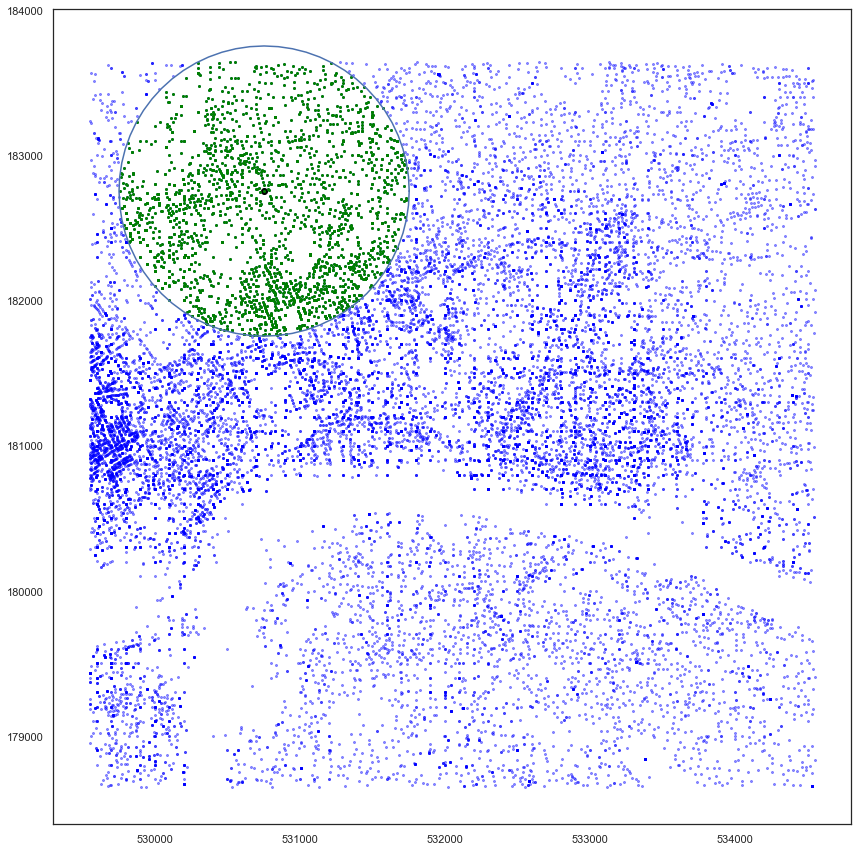

In [ ]:
#add buffer of 1km to the point
point_bf = point.geometry.buffer(1000)

#find the outside of the circle for plotting
x,y = point_bf.exterior.xy

#find the points in the circle
n = points["geometry"].intersection(point_bf)
inside = points[~n.is_empty]

#Plot a map
fig, ax = plt.subplots(1, figsize=(15,15))
points.plot(ax=ax, c="blue", alpha=0.4, markersize=4)
plt.scatter(point.geometry.x,point.geometry.y,c="black")
plt.plot(x,y)
inside.plot(ax=ax, c="green", markersize=4)
plt.show()

In [ ]:
len(points)

34071

In [ ]:
#make a function to do this lots of times
def count_points(df, point, radius):
    point_bf = point.geometry.buffer(radius)
    n = df["geometry"].intersection(point_bf)
    pointcount = len(df[~n.is_empty])
    return pointcount

In [ ]:
count_points(points, point, 1000)

6034

In [ ]:
#Try using within instead
points.within(point.geometry.buffer(1000)).sum()

#I tried but this is so much quicker than my method

6034

In [ ]:
points["postcode_density_1km"] = points.apply(lambda row : points.within(row.geometry.buffer(1000)).sum(), axis = 1)
#this still takes too long for my liking. I'm sure there is a method to use spatial indexes to find this [killed after 10 min]

C:\Users\richa\Anaconda3\envs\GeoData\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
points["Postcode_Density_1km"] = kf.density_within_radius(points,points, 1000)

C:\Users\richa\Anaconda3\envs\GeoData\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
name = "Windermere" 
gdf = kf.load_obj(root_path,"raw_gdf_" + name)

Postcodes = gdf.loc[gdf["Type"]=="Postcodes",["Name", "geometry"]]

Postcodes["Postcode_Density_1km"] = kf.density_within_radius(gdf.loc[gdf["Type"]=="Postcodes",:],gdf.loc[gdf["Type"]=="Postcodes",:], 1000)
Postcodes["Crime_Density_1km"] = kf.density_within_radius(gdf.loc[gdf["Type"]=="Postcodes",:],gdf.loc[gdf["Type"]=="Crimes",:], 1000)
Postcodes["Crime_Rate_1km"] = Postcodes["Crime_Density_1km"] / Postcodes["Postcode_Density_1km"]

Postcodes = Postcodes.rename(columns={"Name": "Postcode"})

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

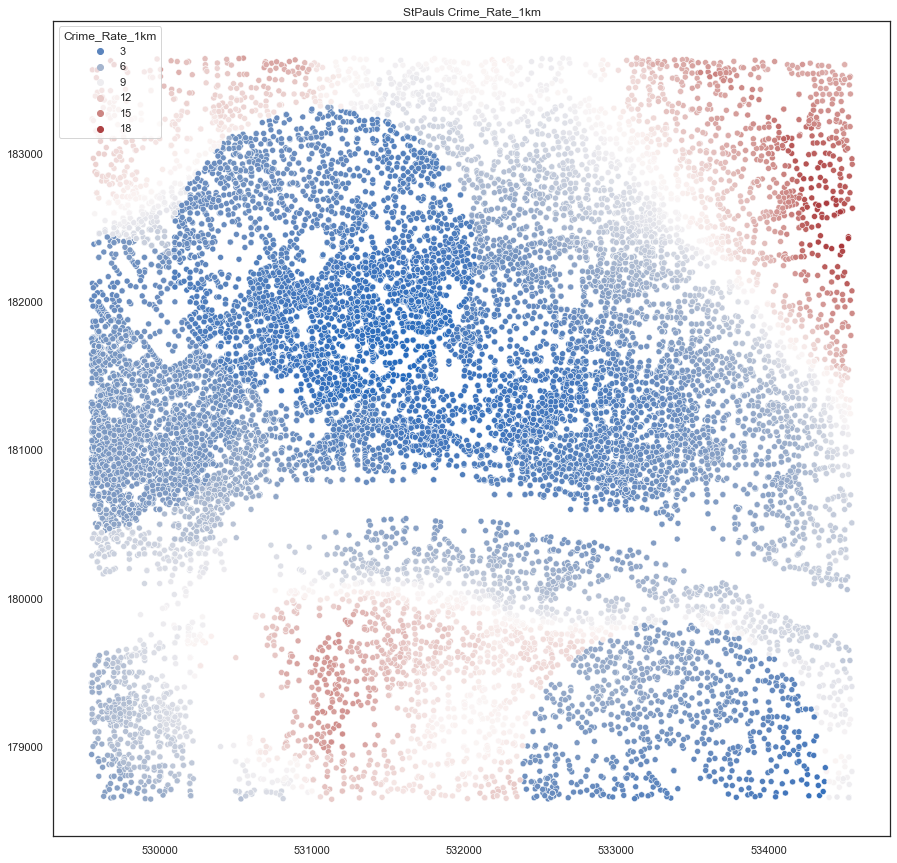

In [ ]:
metric = "Crime_Rate_1km"

fig, ax = plt.subplots(1, figsize=(15,15))
plt.title(name + " " + metric)
sns.scatterplot(x=Postcodes["geometry"].x, y=Postcodes["geometry"].y, data=Postcodes, hue=metric, palette="vlag")
plt.show()


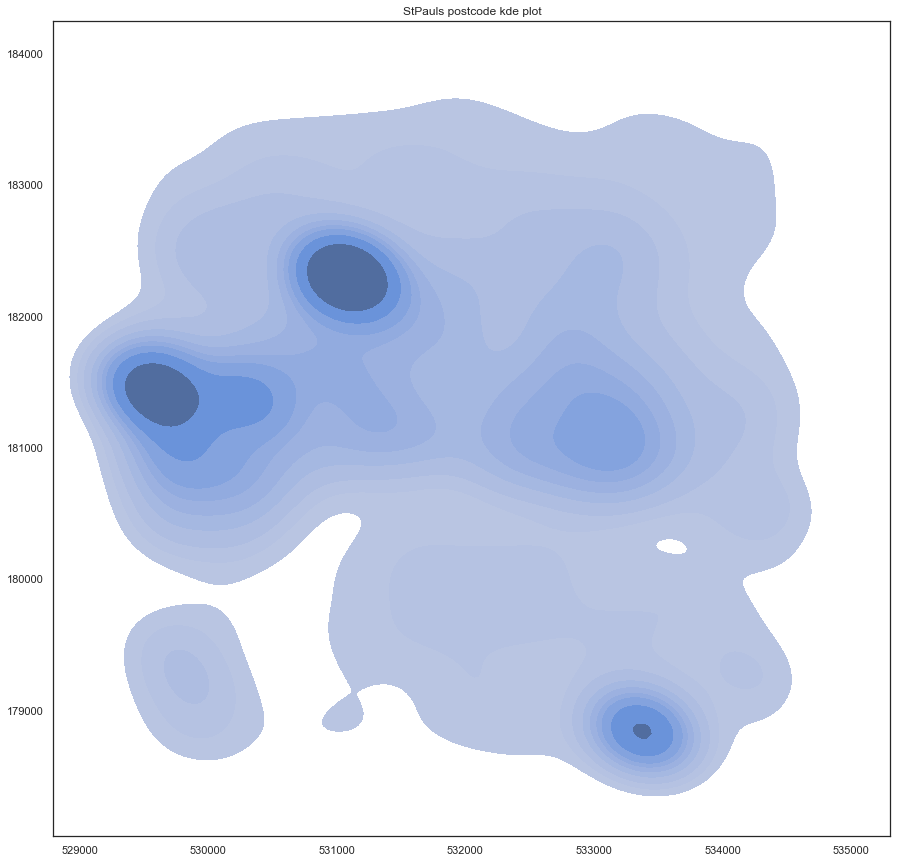

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,15))
plt.title(name + " postcode kde plot")
sns.kdeplot(x=Postcodes["geometry"].x, y=Postcodes["geometry"].y, shade=True, palette="vlag", data=Postcodes)
plt.show()

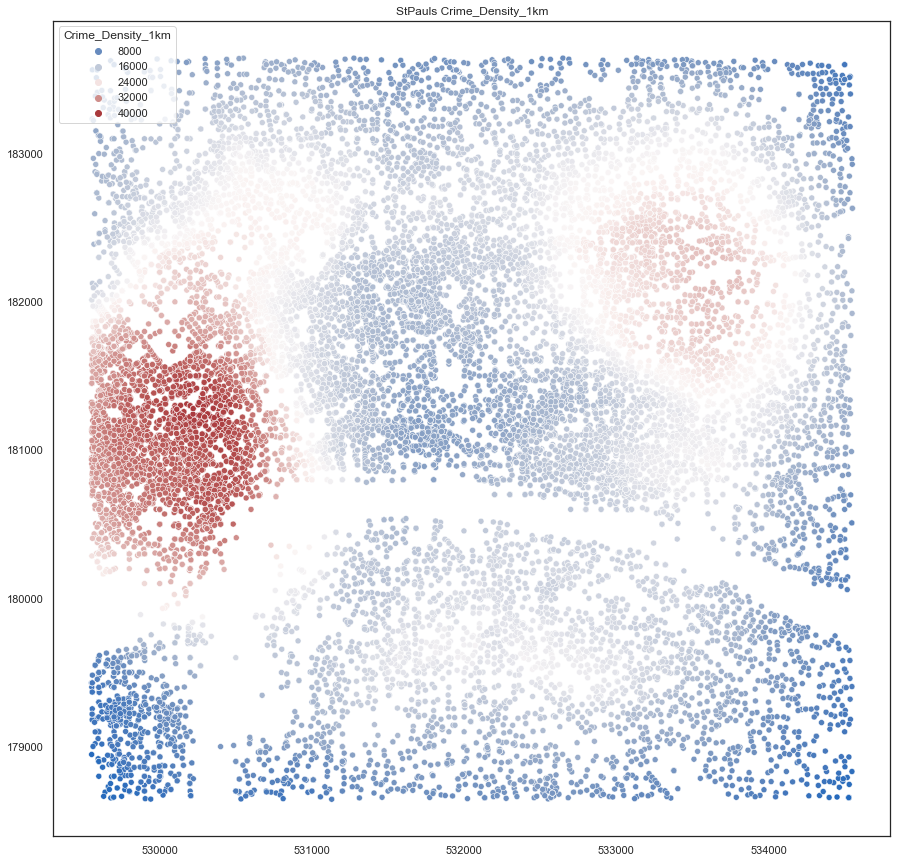

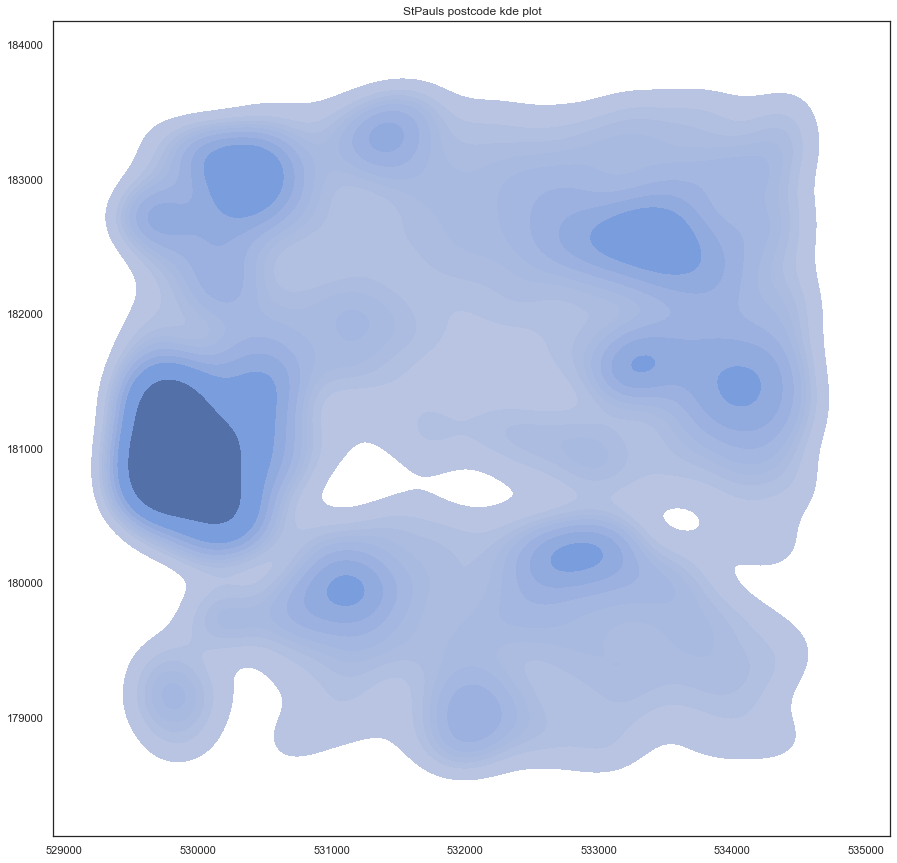

In [ ]:
metric = "Crime_Density_1km"

fig, ax = plt.subplots(1, figsize=(15,15))
plt.title(name + " " + metric)
sns.scatterplot(x=Postcodes["geometry"].x, y=Postcodes["geometry"].y, data=Postcodes, hue=metric, palette="vlag")
plt.show()

pts=gdf.loc[gdf["Type"]=="Crimes",:].copy()

fig, ax = plt.subplots(1, figsize=(15,15))
plt.title(name + " postcode kde plot")
sns.kdeplot(x=pts["geometry"].x, y=pts["geometry"].y, shade=True, palette="vlag")
plt.show()

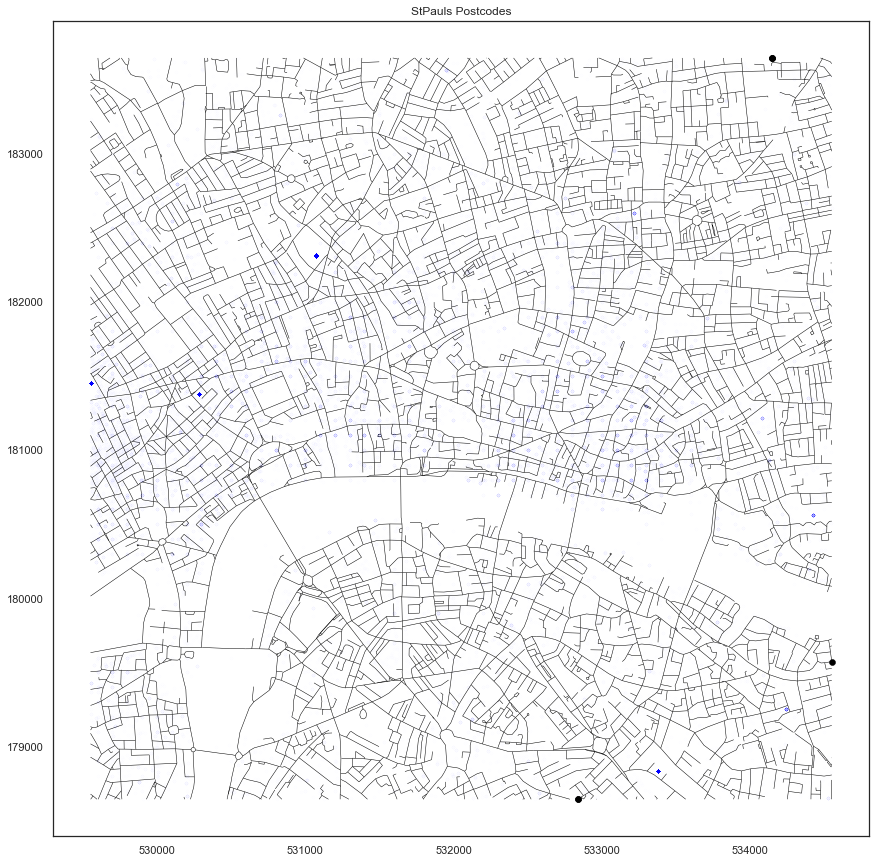

In [ ]:
gdf = kf.load_obj("raw_gdf_" + name)
points = gdf.loc[gdf["Type"]=="Postcodes",:]

fig, ax = plt.subplots(1, figsize=(15,15))
plt.title(name + " Postcodes")

gdf.loc[(gdf["Type"]=="Road"),:].plot(ax=ax, color='black', linewidth=0.5, zorder=1)
points.plot(ax=ax, c="blue", alpha=0.0025, markersize=10)

plt.show()

In [ ]:

m = folium.Map(location=[51.513805, -0.0983777], zoom_start=14, width=1000, height=1000)

folium.Marker(location=[51.524572 , -0.11186957]).add_to(m)
folium.Marker(location=[51.492762 , -0.080151673]).add_to(m)
folium.Marker(location=[51.516541 , -0.12354255]).add_to(m)
m